<a href="https://colab.research.google.com/github/abhishek203/E-Abhishek/blob/master/FinCopyProject_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import keras 
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv1D, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout 
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from google.colab.patches import cv2_imshow
import cv2

Using TensorFlow backend.


In [0]:
url = "https://drive.google.com/open?id=1QRkgQ0dzP_Occx2j-STNl8D2qz-24gM5"
url_id = "1QRkgQ0dzP_Occx2j-STNl8D2qz-24gM5"

In [0]:
!pip install PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id' : url_id})
downloaded.GetContentFile('Emotions.csv')

In [0]:
data = pd.read_csv('Emotions.csv')
data.head()

,emotion,pixels,Usage
0,0,86 104 151 119 35 26 36 36 35 33 31 33 32 34 3...,Training
1,4,30 30 28 30 27 23 11 5 6 9 13 20 34 52 75 106 ...,Training
2,3,226 226 225 223 223 216 210 214 208 198 192 18...,Training
3,4,180 133 85 75 63 63 66 67 66 58 51 66 84 102 1...,Training
4,0,14 15 32 72 82 113 180 147 45 49 54 74 67 79 7...,Training


In [0]:
for i in range(data.shape[0]):
  pix_list = [float(x) for x in data['pixels'][i].split(' ')]
  # pix_list = norm_list(pix_list)
  pix_arr = np.array(pix_list)
  pix_img = np.reshape(pix_arr, (48, 48))
  pix_img_to_list = pix_img.tolist()
  data['pixels'][i] = pix_img_to_list

data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,emotion,pixels,Usage
0,0,"[[86.0, 104.0, 151.0, 119.0, 35.0, 26.0, 36.0,...",Training
1,4,"[[30.0, 30.0, 28.0, 30.0, 27.0, 23.0, 11.0, 5....",Training
2,3,"[[226.0, 226.0, 225.0, 223.0, 223.0, 216.0, 21...",Training
3,4,"[[180.0, 133.0, 85.0, 75.0, 63.0, 63.0, 66.0, ...",Training
4,0,"[[14.0, 15.0, 32.0, 72.0, 82.0, 113.0, 180.0, ...",Training


In [0]:
data['pixels'][0][0][0]

86.0

In [0]:
dftrain = data[data['Usage'] == 'Training']
dfdev = data[data['Usage'] == 'PublicTest']
dftest = data[data['Usage'] == 'PrivateTest']
print(dftrain.shape, dfdev.shape, dftest.shape)

dftrain.head()

(30694, 3) (4089, 3) (4122, 3)


,emotion,pixels,Usage
0,0,"[[86.0, 104.0, 151.0, 119.0, 35.0, 26.0, 36.0,...",Training
1,4,"[[30.0, 30.0, 28.0, 30.0, 27.0, 23.0, 11.0, 5....",Training
2,3,"[[226.0, 226.0, 225.0, 223.0, 223.0, 216.0, 21...",Training
3,4,"[[180.0, 133.0, 85.0, 75.0, 63.0, 63.0, 66.0, ...",Training
4,0,"[[14.0, 15.0, 32.0, 72.0, 82.0, 113.0, 180.0, ...",Training


AxesSubplot(0.125,0.125;0.775x0.755)


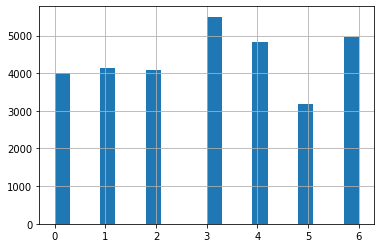

In [0]:
print(dftrain.emotion.hist(bins = 20))
# print(dfdev.emotion.hist(bins = 20))
# print(dftest.emotion.hist(bins = 20))

In [0]:
train_count = dftrain.shape[0]
dev_count = dfdev.shape[0]
test_count = dftest.shape[0]
img_h = 48
img_w = 48

In [0]:
y_train = np.array(dftrain['emotion'])
y_dev = np.array(dfdev['emotion'])
y_test = np.array(dftest['emotion'])

Y_train = tf.keras.utils.to_categorical(y_train, num_classes = 7)
Y_dev = tf.keras.utils.to_categorical(y_dev, num_classes = 7)
Y_test = tf.keras.utils.to_categorical(y_test, num_classes = 7)

# print(Y_train)

In [0]:
def get_X(df, start, end):
  x_list = []
  for i in range(start, end):
    x_list.append(df['pixels'][i])
  X = np.array(x_list)
  X = X / 255
  return X

In [0]:
X_train = get_X(dftrain, 0, train_count)
X_dev = get_X(dfdev, train_count, train_count + dev_count)
X_test = get_X(dftest, train_count + dev_count, train_count + dev_count + test_count)

X_train.shape = (30694, 48, 48, 1)
X_dev.shape = (4089, 48, 48, 1)
X_test.shape = (4122, 48, 48, 1)

In [0]:
def train_Model(input_shape):
  X_input = Input(input_shape)
  X = X_input
  X = Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, padding = "same", name = "CONV1")(X)
  X = BatchNormalization(axis = 3, name = "BN1")(X)
  X = Activation('relu')(X)  
  X = Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, name = "CONV2")(X)
  X = BatchNormalization(axis = 3, name = "BN2")(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2, 2), name = "POOL1")(X)
  X = Dropout(0.05)(X)
  X = Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, padding = "same", name = "CONV3")(X)
  X = BatchNormalization(axis = 3, name = "BN3")(X)
  X = Activation('relu')(X)
  X = Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, name = "CONV4")(X)
  X = BatchNormalization(axis = 3, name = "BN4")(X)
  X = Activation('relu')(X)
  X = Conv2D(filters = 256, kernel_size = (3, 3), strides = 1, padding = "same", name = "CONV5")(X)
  X = BatchNormalization(axis = 3, name = "BN5")(X)
  X = Activation('relu')(X)
  X = Conv2D(filters = 256, kernel_size = (3, 3), strides = 1, name = "CONV6")(X)
  X = BatchNormalization(axis = 3, name = "BN6")(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2, 2), name = "POOL2")(X)
  X = Dropout(0.05)(X)
  X = Flatten()(X)
  X = Dense(1024, activation = "relu", name = "FC1", kernel_regularizer = tf.keras.regularizers.l2(0.001))(X)
  X = Dropout(0.1)(X)
  X = Dense(7, activation = "softmax", name = "Output")(X)

  model = Model(inputs = X_input, outputs = X, name = "Emotion_Model")

  return model

In [0]:
Emotion_Model = train_Model((48, 48, 1))

In [0]:
Emotion_Model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['accuracy'])

In [0]:
Emotion_Model.fit(X_train, Y_train, batch_size = 64, epochs = 5)  # total = 5

In [0]:
Emotion_Model.evaluate(X_dev, Y_dev, batch_size = 64, verbose = 1) 

In [0]:
Emotion_Model.evaluate(X_test, Y_test, batch_size = 64, verbose = 1)